In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits as mpl
from mpl_toolkits.basemap import Basemap
import netCDF4 as ncdf
from datetime import datetime, timedelta
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
# Radiation, Temperature, and Precipitation
monthly_files = [
    "dlwrf.mon.mean.nc",
    "dswrf.mon.mean.nc",
    "ulwrf.sfc.mon.mean.nc",
    "uswrf.sfc.mon.mean.nc",
    "air.sfc.mon.mean.nc",
    "apcp.mon.mean.nc",
    "pevap.mon.mean.nc",
]
names = [
    "dlwrf",
    "dswrf",
    "ulwrf",
    "uswrf",
    "air",
    "apcp",
    "pevap",
    "Rn",
]  # corresponding to each file

pet_file = (
    "pevap.mon.ltm.nc"  # PET is in long term mean, not monthly so is parsed differently
)

aoi = gpd.read_file("data/shp_south_gb/SouthGB_final.shp").iloc[
    0, 1
]  # shapefile for region of interest

In [6]:
# first file to get metadata
data = ncdf.Dataset("data/" + monthly_files[0], "r")

# Formatting the time
zero_time = datetime.strptime(data.variables["time"].units[12:], "%Y-%m-%d %H:%M:%S.%f")
start_hours = data.variables["time"][:][0]
start_time = zero_time + timedelta(hours=start_hours)
end_hours = data.variables["time"][:][data.variables["time"].shape[0] - 1]
end_time = zero_time + timedelta(hours=end_hours)

month_range = pd.date_range(start_time, end_time, freq="MS")  # MS is month start

df = pd.DataFrame(0.0, columns=names, index=month_range)  # Data stored here by month

shape = data.variables["lat"].shape
lons = data.variables["lon"][:]
lats = data.variables["lat"][:]

lat_lon_mask = np.zeros(
    shape
)  # for each lat, lon: 1 if within Area of Interest, 0 otherwise


def contains(lon, lat):
    if aoi.contains(Point(lon, lat)):
        return 1
    else:
        return 0


for i in range(shape[0]):
    for j in range(shape[1]):
        lat_lon_mask[i][j] = contains(lons[i][j], lats[i][j])

lat_lon_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
valid_cells = np.where(lat_lon_mask == 1)

cells = np.sum(lat_lon_mask)

if cells != len(valid_cells[0]):
    print("error error")

dt = data.variables["time"].size

for f in range(len(monthly_files)):
    data = ncdf.Dataset("data/" + monthly_files[f], "r")
    rad = data.variables[names[f]]
    print(rad.shape)  # These should all be the same

    for t in range(dt):
        rad_sum = 0
        for i in range(int(cells)):
            rad_sum += rad[t, valid_cells[0][i], valid_cells[1][i]]

        df.iloc[t, f] = rad_sum / cells

df["Rn"] = df["dlwrf"] + df["dswrf"] - df["ulwrf"] - df["uswrf"]

(541, 277, 349)
(541, 277, 349)
(541, 277, 349)
(541, 277, 349)
(541, 277, 349)
(541, 277, 349)
(541, 277, 349)


In [13]:
df

,dlwrf,dswrf,ulwrf,uswrf,air,apcp,pevap,Rn
1979-01-01,244.234910,132.833453,321.569606,45.198704,274.150784,1.573367,0.210407,10.300053
1979-02-01,236.966659,196.881766,335.283986,62.445428,276.854505,0.691874,0.335009,36.119011
1979-03-01,258.725948,247.254245,365.084732,67.465783,282.782377,1.276042,0.545627,73.429677
1979-04-01,255.693728,330.948998,394.674615,87.430342,288.161401,0.023147,0.904775,104.537769
1979-05-01,286.938989,364.050770,434.307556,94.508451,294.939217,0.084890,1.185304,122.173752
...,...,...,...,...,...,...,...,...
2023-09-01,304.804711,285.652831,444.958107,75.458478,297.017226,0.292334,1.044679,70.040957
2023-10-01,270.380027,229.186325,404.207061,63.639491,289.876313,0.118159,0.722316,31.719800
2023-11-01,240.752273,169.977515,357.544201,50.721479,281.258355,0.155057,0.452674,2.464107
2023-12-01,245.261072,136.844626,342.973677,42.955190,278.481494,0.345031,0.297430,-3.823169


In [8]:
P = df[
    "apcp"
].mean()  # to mm/day; this assumes the pcp means are means of daily intervals
T = df["air"].mean() - 273.15  # to C
Rn = df["Rn"].mean()  # to W/m2
PET = (
    df["pevap"].mean() * 8
)  # to mm/day; this assumes the pevap means are means of 3 hr intervals
values = [P, T, Rn, PET]
print(values)
print(PET * 365)

[0.4788563795862322, 16.178459834339776, 65.73170837646683, 6.655588684135179]
2429.28986970934


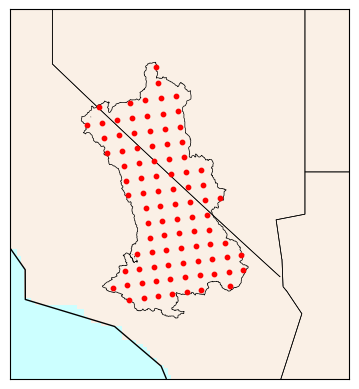

In [19]:
# Visualize study area with shapefile
data = ncdf.Dataset("data/" + monthly_files[0], "r")

lats = data.variables["lat"][:]
lons = data.variables["lon"][:]

plt.figure()
mp = Basemap(
    projection="merc",
    llcrnrlon=-121,
    llcrnrlat=33,
    urcrnrlon=-113,
    urcrnrlat=40,
    resolution="c",
)
mp.drawcoastlines()
mp.drawcountries(linewidth=1)
mp.drawstates()
mp.drawlsmask(land_color="linen", ocean_color="#CCFFFF")
mp.readshapefile("data/shp_south_gb/SouthGB_final", "South Great Basin")

g_lats = []
g_lons = []
for i in range(int(cells)):
    g_lats.append(lats[valid_cells[0][i]][valid_cells[1][i]])
    g_lons.append(lons[valid_cells[0][i]][valid_cells[1][i]])

longi, lati = mp(g_lons, g_lats)

mp.scatter(longi, lati, 10, marker="o", color="r", zorder=5)

In [70]:
# This is to mask across a box

lats = data.variables["lat"][:]
lons = data.variables["lon"][:]
lat_mask = np.zeros((277, 349))
lon_mask = np.zeros((277, 349))

lat_mask[(lats > 30) & (lats < 45)] = 1
lon_mask[(lons > -121) & (lons < -102)] = 1
lat_lon_mask = lat_mask * lon_mask

In [ ]:
# Using np.meshgrid doesn't work because data is not on a lat lon grid
# Tried using xarray flatten for lats and lons but that still doesn't work bc it creates a massive dataset
lon, lat = np.meshgrid(lons, lats)
# x, y = mp(lat, lon)
# print('hello')
# c_schemes = mp.pcolor(x, y, np.squeeze(rad[0,:,:]), cmap='jet')
# #
# # print('hello')
# plt.show()

In [5]:
# Extract Data for creating map of study area
# This is basically the same as above but for a rectangle
lllat = 30
urlat = 40
lllon = -121
urlon = -113
# lllat = 30
# urlat = 31
# lllon = -121
# urlon = -120

files = ["air.sfc.mon.mean.nc", "apcp.mon.mean.nc"]
columns = ["air", "apcp", "lat", "lon", "time"]

# first file to get metadata
data = ncdf.Dataset("data/" + files[0], "r")

dt = data.variables["time"].size

# Formatting the time
zero_time = datetime.strptime(data.variables["time"].units[12:], "%Y-%m-%d %H:%M:%S.%f")
start_hours = data.variables["time"][:][0]
start_time = zero_time + timedelta(hours=start_hours)
end_hours = data.variables["time"][:][data.variables["time"].shape[0] - 1]
end_time = zero_time + timedelta(hours=end_hours)

month_range = pd.date_range(start_time, end_time, freq="MS")  # MS is month start

shape = data.variables["lat"].shape
lons = data.variables["lon"][:]
lats = data.variables["lat"][:]

lat_lon_mask = np.zeros(
    shape
)  # for each lat, lon: 1 if within Area of Interest, 0 otherwise


def contains(lon, lat):
    if lat > lllat and lat < urlat and lon > lllon and lon < urlon:
        return 1
    else:
        return 0


for i in range(shape[0]):
    for j in range(shape[1]):
        lat_lon_mask[i][j] = contains(lons[i][j], lats[i][j])

valid_cells = np.where(lat_lon_mask == 1)

index = np.linspace(0, (dt * len(valid_cells[0])), dt * len(valid_cells[0])).astype(int)

df = pd.DataFrame(0.0, columns=columns, index=index)  # Data stored here by month

# for i in index:
#     df['lat'].iloc[i] = lats[valid_cells[0][i], valid_cells[1][i]]
#     df['lon'].iloc[i] = lons[valid_cells[0][i], valid_cells[1][i]]
# df
cells = np.sum(lat_lon_mask)

if cells != len(valid_cells[0]):
    print("error error")

for f in range(len(files)):
    data = ncdf.Dataset("data/" + files[f], "r")
    item = data.variables[columns[f]]
    time = data.variables["time"][:]
    print(item.shape)  # These should all be the same

    x = 0

    for i in range(int(cells)):
        print(f"file {f+1}/{len(files)}; cell {i+1}/{int(cells)}")

        climate_sum = 0
        for t in range(dt):
            value = item[t, valid_cells[0][i], valid_cells[1][i]]
            df.iloc[x, f] = value
            df.iloc[x, 2] = lats[valid_cells[0][i], valid_cells[1][i]]
            df.iloc[x, 3] = lons[valid_cells[0][i], valid_cells[1][i]]
            df.iloc[x, 4] = zero_time + timedelta(hours=time[t])
            x += 1

# make columns for lat and lon in df

df["air"] = df["air"] - 273.15  # to C
df

(541, 277, 349)
file 1/2; cell 1/821


/var/folders/0_/6qq47rd13fg812z0mqvx216w0000gn/T/ipykernel_7943/20084899.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1979-01-01 00:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[x, 4] = zero_time + timedelta(hours=time[t])


file 1/2; cell 2/821
file 1/2; cell 3/821
file 1/2; cell 4/821
file 1/2; cell 5/821
file 1/2; cell 6/821
file 1/2; cell 7/821
file 1/2; cell 8/821
file 1/2; cell 9/821
file 1/2; cell 10/821
file 1/2; cell 11/821
file 1/2; cell 12/821
file 1/2; cell 13/821
file 1/2; cell 14/821
file 1/2; cell 15/821
file 1/2; cell 16/821
file 1/2; cell 17/821
file 1/2; cell 18/821
file 1/2; cell 19/821
file 1/2; cell 20/821
file 1/2; cell 21/821
file 1/2; cell 22/821
file 1/2; cell 23/821
file 1/2; cell 24/821
file 1/2; cell 25/821
file 1/2; cell 26/821
file 1/2; cell 27/821
file 1/2; cell 28/821
file 1/2; cell 29/821
file 1/2; cell 30/821
file 1/2; cell 31/821
file 1/2; cell 32/821
file 1/2; cell 33/821
file 1/2; cell 34/821
file 1/2; cell 35/821
file 1/2; cell 36/821
file 1/2; cell 37/821
file 1/2; cell 38/821
file 1/2; cell 39/821
file 1/2; cell 40/821
file 1/2; cell 41/821
file 1/2; cell 42/821
file 1/2; cell 43/821
file 1/2; cell 44/821
file 1/2; cell 45/821
file 1/2; cell 46/821
file 1/2; cell 47/

,air,apcp,lat,lon,time
0,13.591211,1.528065,30.030251,-115.799400,1979-01-01 00:00:00
1,15.163354,0.323061,30.030251,-115.799400,1979-02-01 00:00:00
2,17.349573,0.635686,30.030251,-115.799400,1979-03-01 00:00:00
3,20.488977,0.008801,30.030251,-115.799400,1979-04-01 00:00:00
4,22.236993,0.022080,30.030251,-115.799400,1979-05-01 00:00:00
...,...,...,...,...,...
444156,15.344324,0.958568,39.987720,-120.790901,2023-09-01 00:00:00
444157,9.859064,0.219020,39.987720,-120.790901,2023-10-01 00:00:00
444158,2.450861,1.742891,39.987720,-120.790901,2023-11-01 00:00:00
444159,-0.536658,3.057584,39.987720,-120.790901,2023-12-01 00:00:00


In [6]:
df.to_csv("data/climate_data.csv", index=False)

In [7]:
df

,air,apcp,lat,lon,time
0,0.000000,0.0,0.00000,0.000000,0.0
1,288.838226,0.0,30.00713,-120.311897,1979-01-01 00:00:00
2,287.975464,0.0,30.00713,-120.311897,1979-02-01 00:00:00
3,288.246521,0.0,30.00713,-120.311897,1979-03-01 00:00:00
4,288.583496,0.0,30.00713,-120.311897,1979-04-01 00:00:00
...,...,...,...,...,...
5946,292.018005,0.0,30.87348,-120.165398,2023-08-01 00:00:00
5947,293.131836,0.0,30.87348,-120.165398,2023-09-01 00:00:00
5948,292.533783,0.0,30.87348,-120.165398,2023-10-01 00:00:00
5949,291.805267,0.0,30.87348,-120.165398,2023-11-01 00:00:00
